# Подготовка библиотек

In [1]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 35.92 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split

# Проверить устройства для кераса

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6615266812008459107
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1971140916280893291
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Функции для визуализации

In [4]:
def display(display_list):
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Загрузка датасета и обработка

In [5]:
DATASET_PATH = 'clothing-co-parsing/photos/'
MASKS_PATH = 'clothing-co-parsing/annotations/pixel-level/'

In [6]:
def preprocess_image(image):
     image = tf.cast(image, tf.float32)
     # scale values to [0,1]
     image = image/255.0
     # resize image
     image = tf.image.resize(image, (128,128))
     return image 
     

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    # будем использовать бинарную классификацию - фон и человек
    # для этого фон, закодированный нулем, оставим нулевым
    # все остальное будет равно единице
    mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [7]:
images = []
masks = []

for mask_filename in os.listdir(MASKS_PATH):
  image_filename = mask_filename[:-4] + '.jpg'
  image = img_to_array(load_img(DATASET_PATH + image_filename))
  images.append(preprocess_image(image))
      
  mask_file = io.loadmat(MASKS_PATH + mask_filename)
  mask = tf.convert_to_tensor(mask_file['groundtruth']) 
  masks.append(preprocess_mask(mask))

In [8]:
train_X, test_X, train_Y, test_Y = train_test_split(images, masks,\
                                                 test_size=0.2, random_state=0)
sample_image, sample_mask = train_X[0], train_Y[0]

train_X = tf.data.Dataset.from_tensor_slices(train_X)
test_X = tf.data.Dataset.from_tensor_slices(test_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)

train = tf.data.Dataset.zip((train_X, train_Y))
test = tf.data.Dataset.zip((test_X, test_Y)) 

In [9]:
# функции для аугментации 

# яркость
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# оттенок
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# отзеркаливание по горизонтали
def flip_horisontal(img, mask):
     img = tf.image.flip_left_right(img)
     mask = tf.image.flip_left_right(mask)
     return img, mask

In [10]:
# последовательно применяем аугментации
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))

In [11]:
len(train)

6424

In [12]:
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE) 

далее обучайте на датасете train, для валидации используйте датасет test аналогично как на занятии

In [13]:
tf.random.set_seed(12)
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

# down_stack.trainable = False

up_stack = [
    tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu')
]




9420800/9406464 [==============================] - 0s 0us/step


In [14]:
def resolution_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(output_channels, 2, strides=2, 
                                         padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
OUTPUT_CHANNELS = 2

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

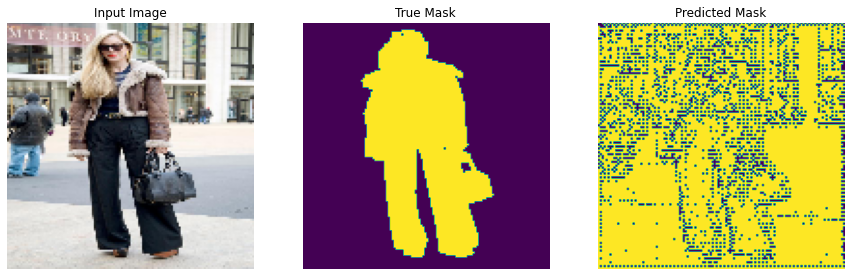

In [17]:
show_predictions(model)

Epoch 1/10
  6/201 [..............................] - ETA: 22s - loss: 0.8555 - accuracy: 0.5244

201/201 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9413

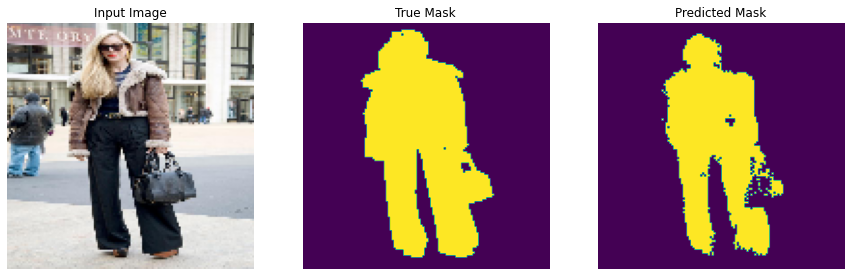


Sample Prediction after epoch 1

201/201 [==============================] - 34s 133ms/step - loss: 0.1318 - accuracy: 0.9413 - val_loss: 0.2396 - val_accuracy: 0.9277
Epoch 2/10
201/201 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9826

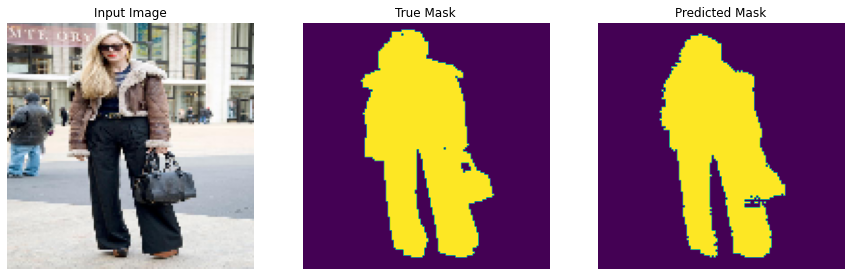


Sample Prediction after epoch 2

201/201 [==============================] - 25s 123ms/step - loss: 0.0443 - accuracy: 0.9826 - val_loss: 0.1324 - val_accuracy: 0.9599
Epoch 3/10
201/201 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9867

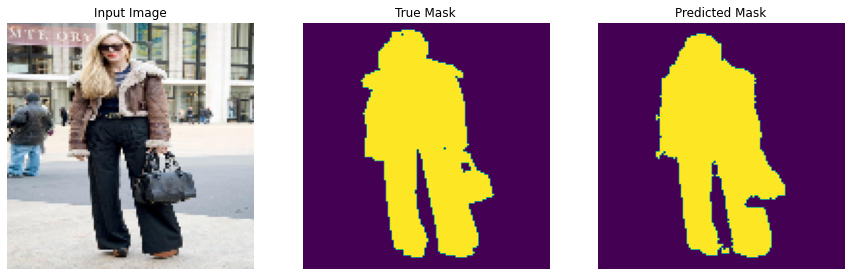


Sample Prediction after epoch 3

201/201 [==============================] - 25s 126ms/step - loss: 0.0335 - accuracy: 0.9867 - val_loss: 0.1356 - val_accuracy: 0.9637
Epoch 4/10
201/201 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9888

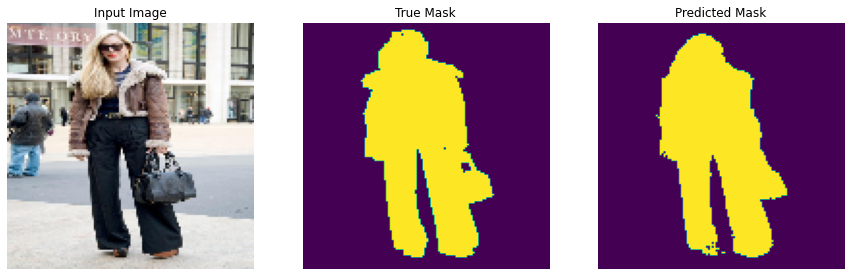


Sample Prediction after epoch 4

201/201 [==============================] - 26s 127ms/step - loss: 0.0281 - accuracy: 0.9888 - val_loss: 0.1329 - val_accuracy: 0.9667
Epoch 5/10
201/201 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9903

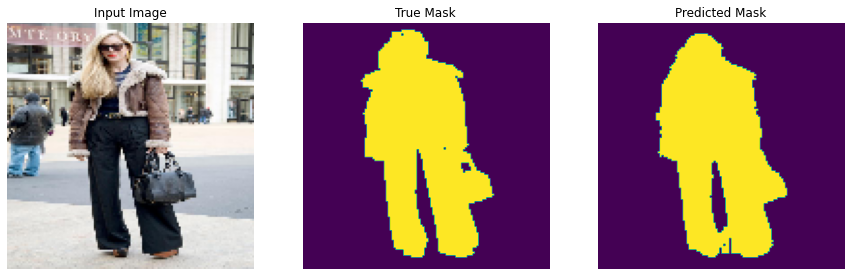


Sample Prediction after epoch 5

201/201 [==============================] - 25s 126ms/step - loss: 0.0242 - accuracy: 0.9903 - val_loss: 0.1117 - val_accuracy: 0.9719
Epoch 6/10
201/201 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9912

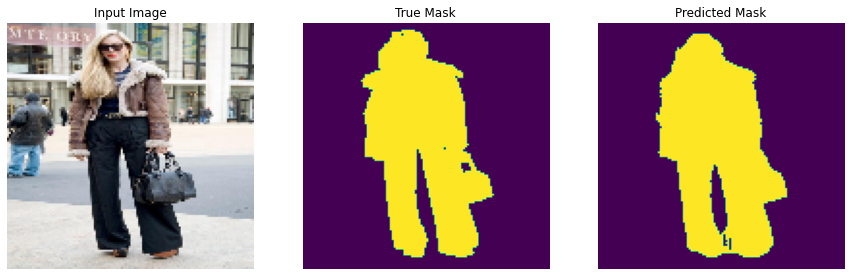


Sample Prediction after epoch 6

201/201 [==============================] - 25s 126ms/step - loss: 0.0218 - accuracy: 0.9912 - val_loss: 0.1046 - val_accuracy: 0.9736
Epoch 7/10
201/201 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9922

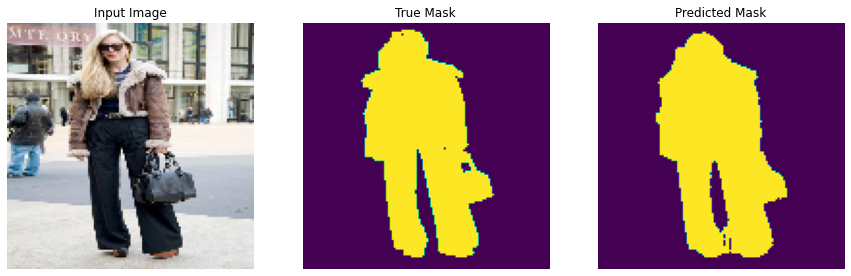


Sample Prediction after epoch 7

201/201 [==============================] - 26s 128ms/step - loss: 0.0194 - accuracy: 0.9922 - val_loss: 0.1002 - val_accuracy: 0.9745
Epoch 8/10
201/201 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9928

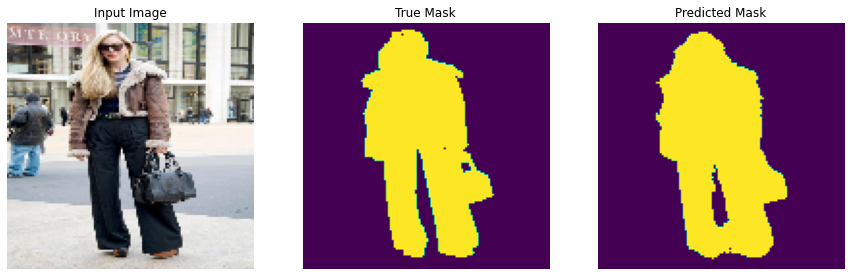


Sample Prediction after epoch 8

201/201 [==============================] - 25s 125ms/step - loss: 0.0178 - accuracy: 0.9928 - val_loss: 0.0984 - val_accuracy: 0.9760
Epoch 9/10
201/201 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9935

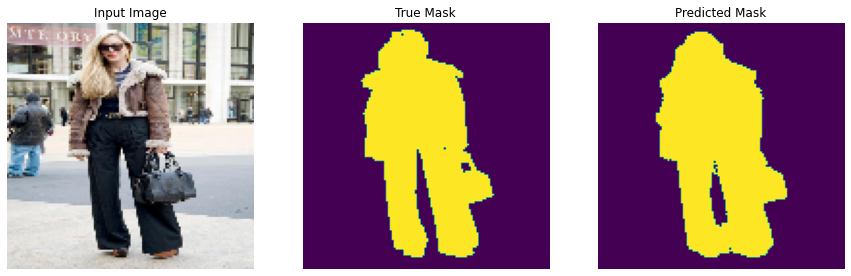


Sample Prediction after epoch 9

201/201 [==============================] - 25s 124ms/step - loss: 0.0161 - accuracy: 0.9935 - val_loss: 0.0970 - val_accuracy: 0.9771
Epoch 10/10
201/201 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9941

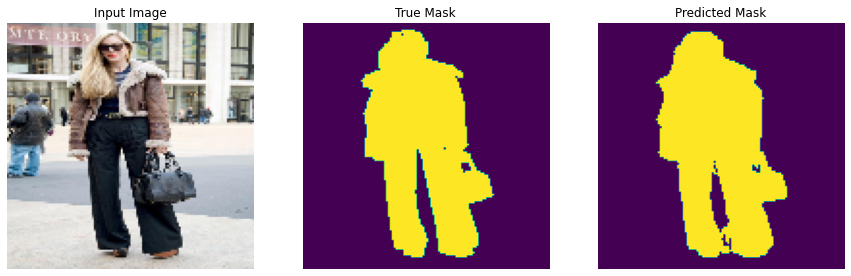


Sample Prediction after epoch 10

201/201 [==============================] - 26s 128ms/step - loss: 0.0148 - accuracy: 0.9941 - val_loss: 0.0958 - val_accuracy: 0.9779


In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions(model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# 10 эпох, буфер 500, батч 32, предобученные слои, 2 класса

EPOCHS = 10 # увеличьте при необходимости

model_history = model.fit(train, epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test,
                          callbacks=[DisplayCallback()])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

In [21]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

def build_model():
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(2, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


  6/201 [..............................] - ETA: 18s - loss: 0.5444 - accuracy: 0.7485

201/201 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9039

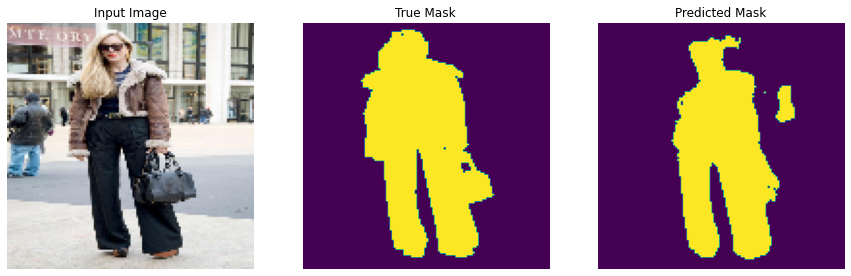


Sample Prediction after epoch 1

201/201 [==============================] - 20s 91ms/step - loss: 0.2284 - accuracy: 0.9039 - val_loss: 0.1798 - val_accuracy: 0.9312
Epoch 2/10
201/201 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9562

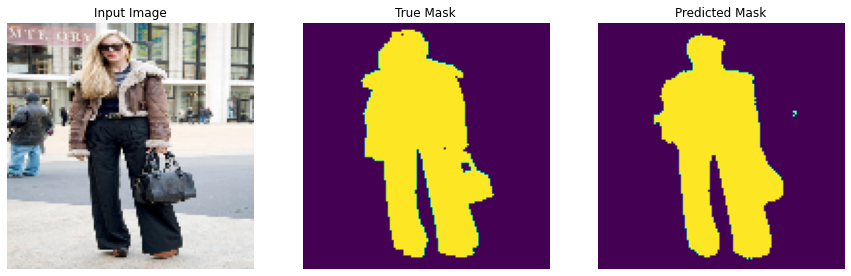


Sample Prediction after epoch 2

201/201 [==============================] - 18s 88ms/step - loss: 0.1119 - accuracy: 0.9562 - val_loss: 0.1046 - val_accuracy: 0.9590
Epoch 3/10
201/201 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9674

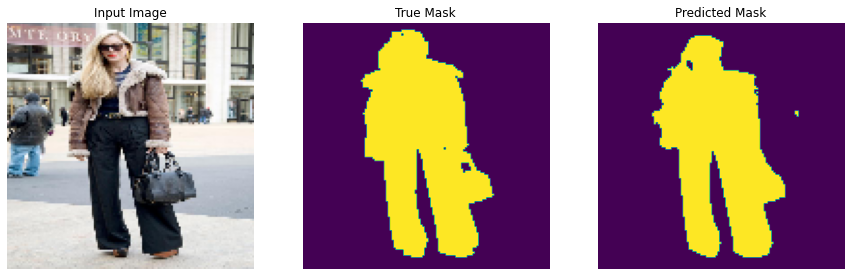


Sample Prediction after epoch 3

201/201 [==============================] - 18s 88ms/step - loss: 0.0839 - accuracy: 0.9674 - val_loss: 0.0893 - val_accuracy: 0.9656
Epoch 4/10
201/201 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9735

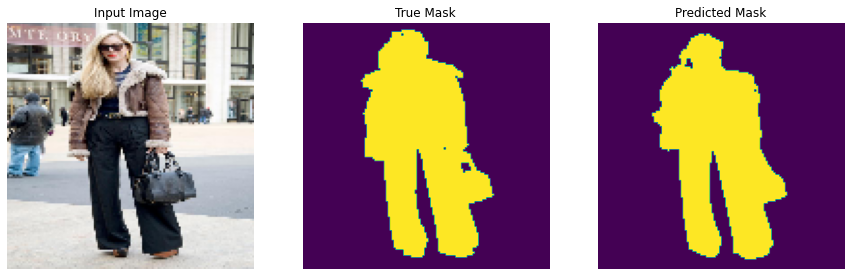


Sample Prediction after epoch 4

201/201 [==============================] - 18s 87ms/step - loss: 0.0679 - accuracy: 0.9735 - val_loss: 0.0756 - val_accuracy: 0.9715
Epoch 5/10
201/201 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9774

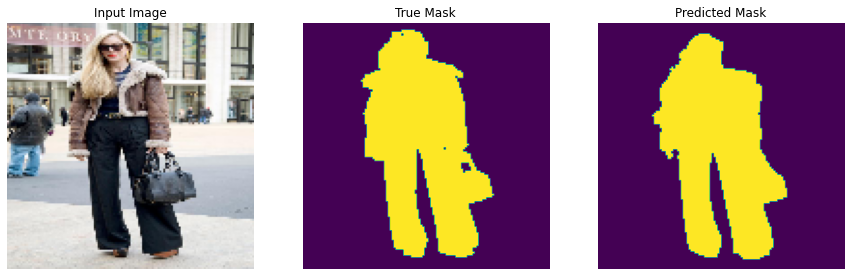


Sample Prediction after epoch 5

201/201 [==============================] - 18s 89ms/step - loss: 0.0582 - accuracy: 0.9774 - val_loss: 0.0715 - val_accuracy: 0.9736
Epoch 6/10
201/201 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9804

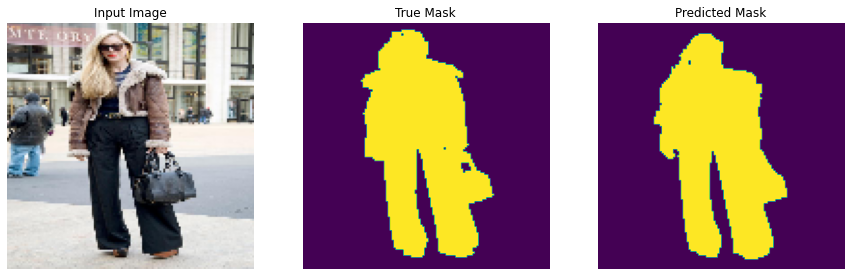


Sample Prediction after epoch 6

201/201 [==============================] - 18s 89ms/step - loss: 0.0503 - accuracy: 0.9804 - val_loss: 0.0689 - val_accuracy: 0.9755
Epoch 7/10
201/201 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9824

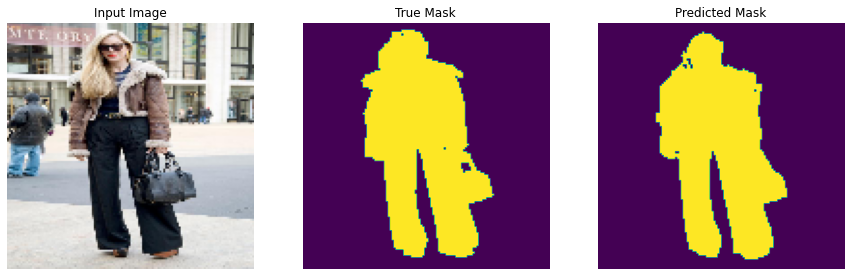


Sample Prediction after epoch 7

201/201 [==============================] - 18s 89ms/step - loss: 0.0452 - accuracy: 0.9824 - val_loss: 0.0700 - val_accuracy: 0.9752
Epoch 8/10
201/201 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9841

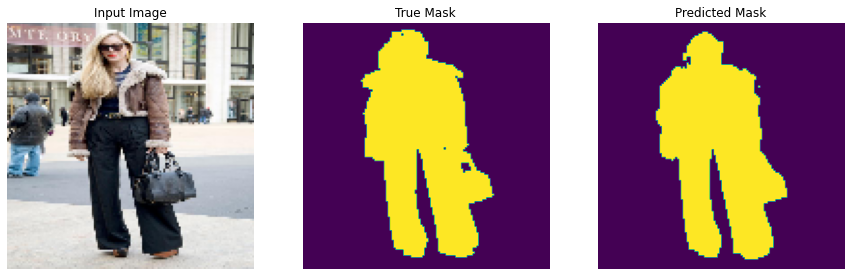


Sample Prediction after epoch 8

201/201 [==============================] - 18s 88ms/step - loss: 0.0409 - accuracy: 0.9841 - val_loss: 0.0689 - val_accuracy: 0.9770
Epoch 9/10
201/201 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9852

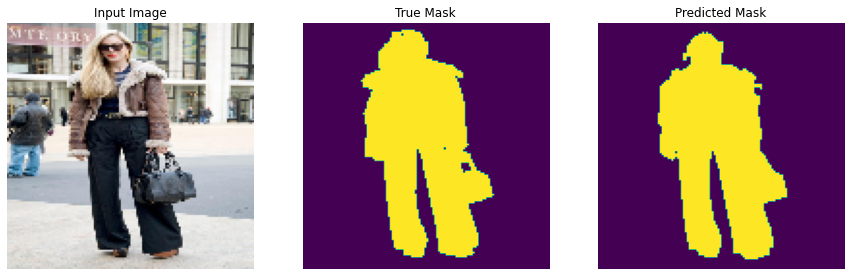


Sample Prediction after epoch 9

201/201 [==============================] - 18s 89ms/step - loss: 0.0379 - accuracy: 0.9852 - val_loss: 0.0675 - val_accuracy: 0.9779
Epoch 10/10
201/201 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9860

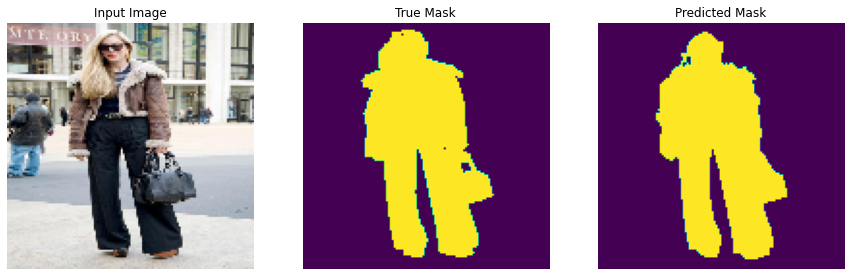


Sample Prediction after epoch 10

201/201 [==============================] - 18s 89ms/step - loss: 0.0360 - accuracy: 0.9860 - val_loss: 0.0647 - val_accuracy: 0.9790


In [22]:
# 10 эпох, буфер 500, батч 32, сеть обучается с нуля, 2 класса



model = build_model()
model_history = model.fit(train, epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test,
                          callbacks=[DisplayCallback()])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

In [23]:
BUFFER_SIZE = 1000
OUTPUT_CHANNELS = 2

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Epoch 1/10
  6/201 [..............................] - ETA: 24s - loss: 1.1989 - accuracy: 0.6317

201/201 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9688

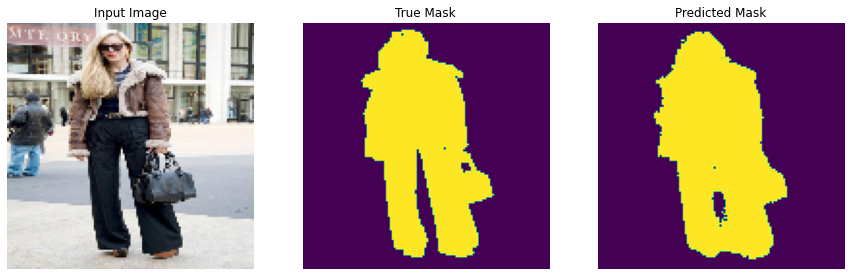


Sample Prediction after epoch 1

201/201 [==============================] - 32s 135ms/step - loss: 0.0890 - accuracy: 0.9688 - val_loss: 0.0881 - val_accuracy: 0.9750
Epoch 2/10
201/201 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9921

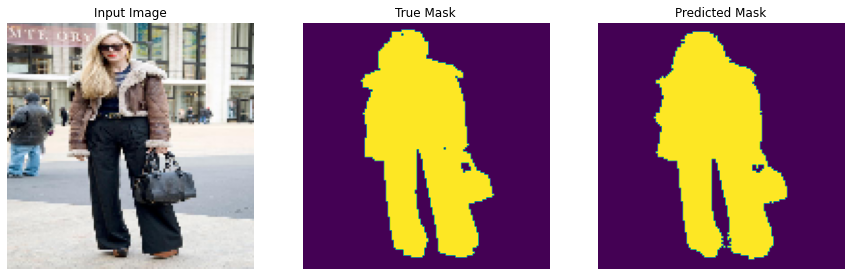


Sample Prediction after epoch 2

201/201 [==============================] - 25s 124ms/step - loss: 0.0195 - accuracy: 0.9921 - val_loss: 0.0902 - val_accuracy: 0.9768
Epoch 3/10
201/201 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9935

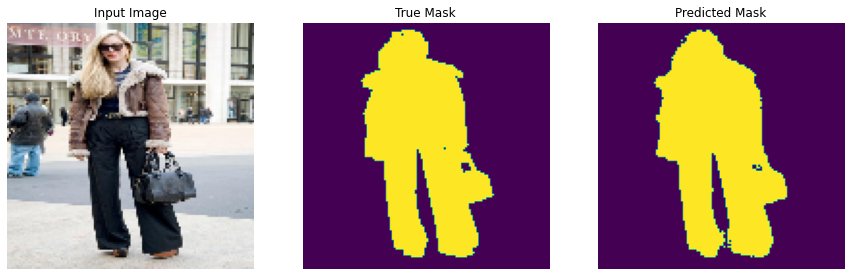


Sample Prediction after epoch 3

201/201 [==============================] - 26s 127ms/step - loss: 0.0161 - accuracy: 0.9935 - val_loss: 0.0955 - val_accuracy: 0.9770
Epoch 4/10
201/201 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9942

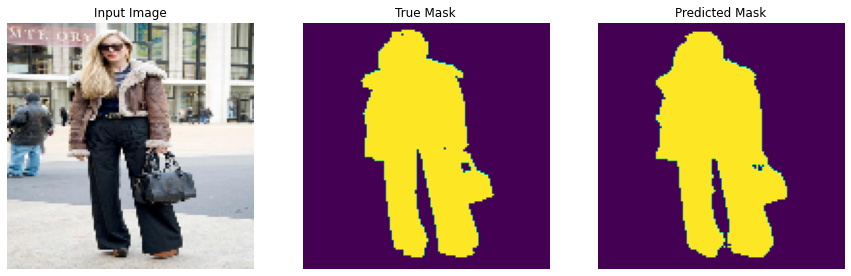


Sample Prediction after epoch 4

201/201 [==============================] - 26s 128ms/step - loss: 0.0145 - accuracy: 0.9942 - val_loss: 0.0934 - val_accuracy: 0.9779
Epoch 5/10
201/201 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.9947

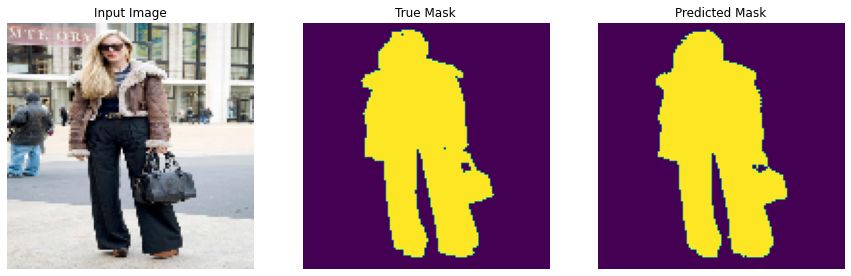


Sample Prediction after epoch 5

201/201 [==============================] - 26s 129ms/step - loss: 0.0132 - accuracy: 0.9947 - val_loss: 0.0955 - val_accuracy: 0.9781
Epoch 6/10
201/201 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9951

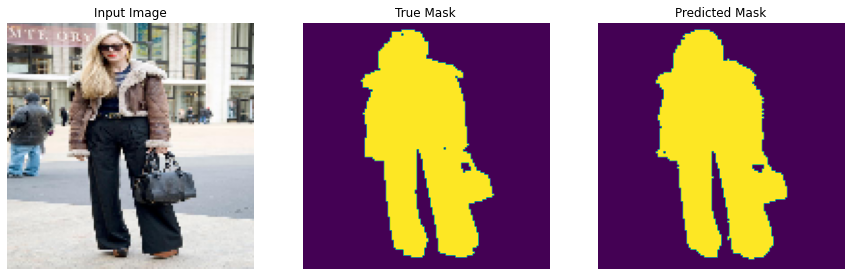


Sample Prediction after epoch 6

201/201 [==============================] - 26s 131ms/step - loss: 0.0122 - accuracy: 0.9951 - val_loss: 0.0983 - val_accuracy: 0.9784
Epoch 7/10
201/201 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9953

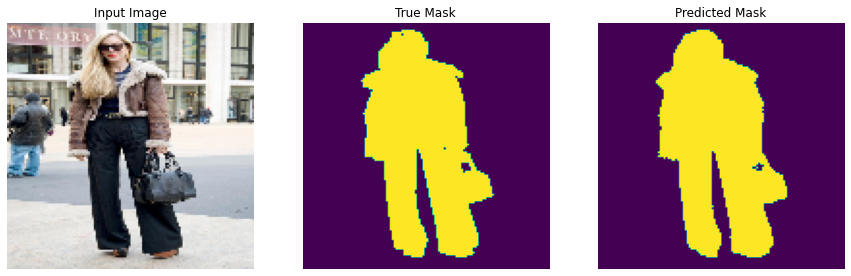


Sample Prediction after epoch 7

201/201 [==============================] - 26s 129ms/step - loss: 0.0119 - accuracy: 0.9953 - val_loss: 0.0961 - val_accuracy: 0.9788
Epoch 8/10
201/201 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9957

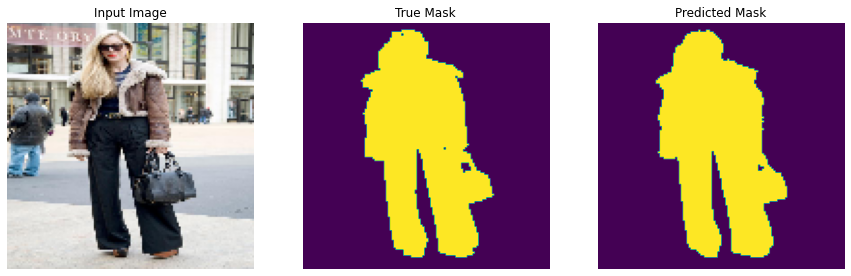


Sample Prediction after epoch 8

201/201 [==============================] - 26s 129ms/step - loss: 0.0108 - accuracy: 0.9957 - val_loss: 0.1018 - val_accuracy: 0.9785
Epoch 9/10
201/201 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9960

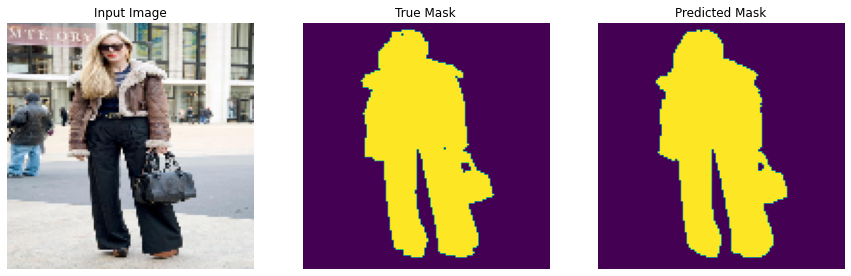


Sample Prediction after epoch 9

201/201 [==============================] - 27s 132ms/step - loss: 0.0101 - accuracy: 0.9960 - val_loss: 0.1061 - val_accuracy: 0.9785
Epoch 10/10
201/201 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9962

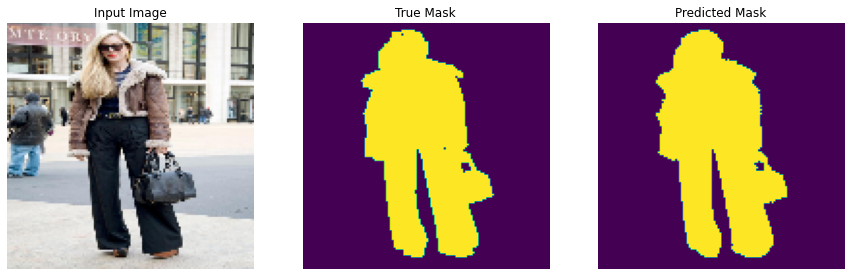


Sample Prediction after epoch 10

201/201 [==============================] - 26s 129ms/step - loss: 0.0096 - accuracy: 0.9962 - val_loss: 0.1058 - val_accuracy: 0.9791


In [24]:
#буфер 100, батч 32, предобученные слои
EPOCHS = 10 # увеличьте при необходимости

model_history = model.fit(train, epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test,
                          callbacks=[DisplayCallback()])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

In [35]:
def preprocess_image(image):
     image = tf.cast(image, tf.float32)
     # scale values to [0,1]
     image = image/255.0
     # resize image
     image = tf.image.resize(image, (128,128))
     return image 
     

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    # будем использовать бинарную классификацию - фон и человек
    # для этого фон, закодированный нулем, оставим нулевым
    # все остальное будет равно единице
    # mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [36]:
images = []
masks = []

for mask_filename in os.listdir(MASKS_PATH):
  image_filename = mask_filename[:-4] + '.jpg'
  image = img_to_array(load_img(DATASET_PATH + image_filename))
  images.append(preprocess_image(image))
      
  mask_file = io.loadmat(MASKS_PATH + mask_filename)
  mask = tf.convert_to_tensor(mask_file['groundtruth']) 
  masks.append(preprocess_mask(mask))

In [37]:
train_X, test_X, train_Y, test_Y = train_test_split(images, masks,\
                                                 test_size=0.2, random_state=0)
sample_image, sample_mask = train_X[0], train_Y[0]

train_X = tf.data.Dataset.from_tensor_slices(train_X)
test_X = tf.data.Dataset.from_tensor_slices(test_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)

train = tf.data.Dataset.zip((train_X, train_Y))
test = tf.data.Dataset.zip((test_X, test_Y)) 

In [38]:
# последовательно применяем аугментации
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))

In [39]:
def resolution_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(output_channels, 69, strides=2, 
                                         padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [42]:
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE) 

In [43]:
BUFFER_SIZE = 1000
OUTPUT_CHANNELS = 69

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_4[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

Epoch 1/10
  6/201 [..............................] - ETA: 1:14:39 - loss: 60.6856 - accuracy: 0.4495

201/201 [==============================] - ETA: 0s - loss: 22.5753 - accuracy: 0.7278 

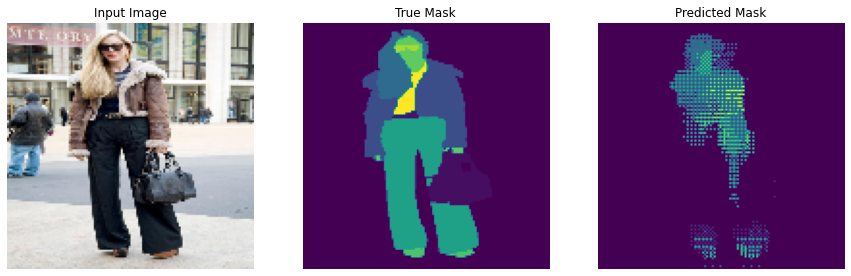


Sample Prediction after epoch 1

201/201 [==============================] - 5166s 24s/step - loss: 22.5753 - accuracy: 0.7278 - val_loss: 9.9464 - val_accuracy: 0.7708
Epoch 2/10
201/201 [==============================] - ETA: 0s - loss: 6.4001 - accuracy: 0.7815 

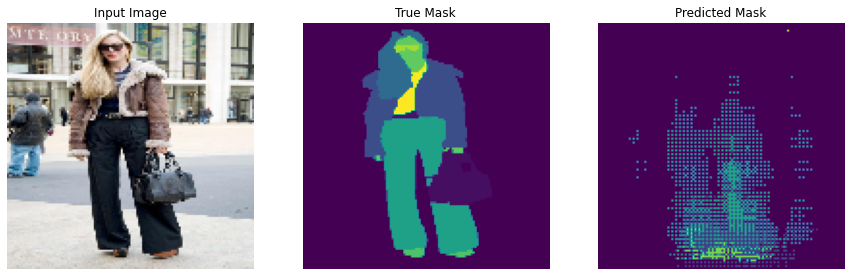


Sample Prediction after epoch 2

201/201 [==============================] - 4714s 23s/step - loss: 6.4001 - accuracy: 0.7815 - val_loss: 12.8463 - val_accuracy: 0.7185
Epoch 3/10
201/201 [==============================] - ETA: 0s - loss: 3.4078 - accuracy: 0.7975 

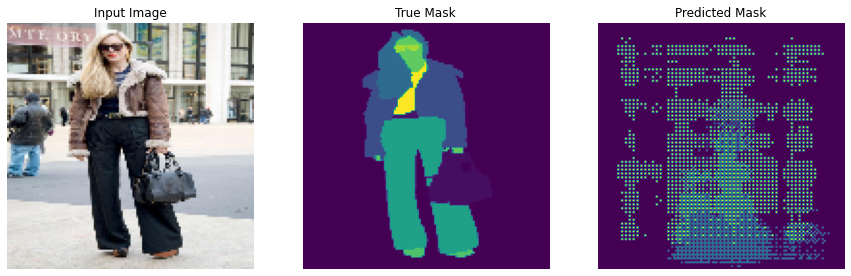


Sample Prediction after epoch 3

201/201 [==============================] - 4727s 24s/step - loss: 3.4078 - accuracy: 0.7975 - val_loss: 11.6910 - val_accuracy: 0.6537
Epoch 4/10
201/201 [==============================] - ETA: 0s - loss: 2.1486 - accuracy: 0.8200 

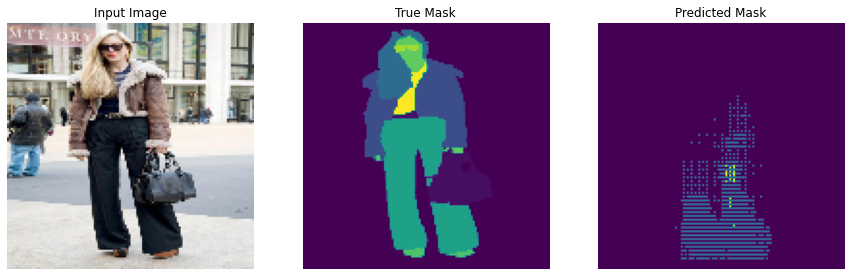


Sample Prediction after epoch 4

201/201 [==============================] - 4747s 24s/step - loss: 2.1486 - accuracy: 0.8200 - val_loss: 7.1605 - val_accuracy: 0.7348
Epoch 5/10
201/201 [==============================] - ETA: 0s - loss: 1.3772 - accuracy: 0.8432 

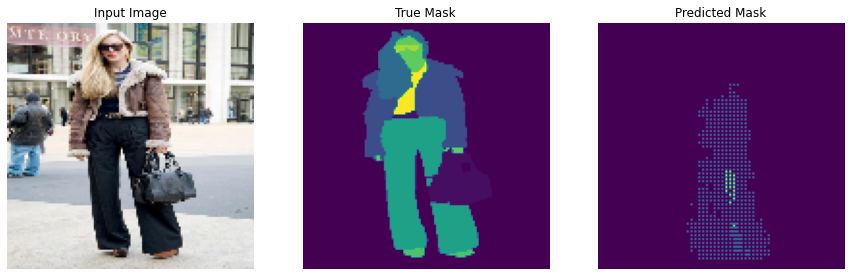


Sample Prediction after epoch 5

201/201 [==============================] - 4755s 24s/step - loss: 1.3772 - accuracy: 0.8432 - val_loss: 5.8706 - val_accuracy: 0.7578
Epoch 6/10
102/201 [==============>...............] - ETA: 38:37 - loss: 1.4617 - accuracy: 0.8548

In [ ]:
#буфер 100, батч 32, предобученные слои, 69 коассов
EPOCHS = 10 # увеличьте при необходимости

model_history = model.fit(train, epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test,
                          callbacks=[DisplayCallback()])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']